In [40]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

import ccxt as cx
import ccxt.pro as cxp
from ccxt.base.decimal_to_precision import ROUND_UP
import asyncio
import nest_asyncio
nest_asyncio.apply()

import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup
from qubx.core.basics import Trade, Quote
from qubx.core.series import TimeSeries
from qubx.impl.ccxt_connector import CCXT_connector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Common

In [ ]:
lookup.instruments['KRAKEN.F:BTC/USD']

In [34]:
instr = lookup.instruments.find('BINANCE.UM', 'BTC', 'USDT')
instr

Instrument(symbol='BTCUSDT', market_type='CRYPTO', exchange='BINANCE.UM', base='BTC', quote='USDT', margin_symbol='USDT', min_tick=0.1, min_size_step=0.001, min_size=0.001, futures_info=FuturesInfo(contract_type='PERPETUAL', delivery_date=datetime.datetime(2100, 12, 25, 10, 0), onboard_date=datetime.datetime(2019, 9, 25, 11, 0), contract_size=1.0, maint_margin=2.5, required_margin=5.0, liquidation_fee=0.0125), _aux_instrument=None)

In [39]:
instr = lookup.instruments.find('KRAKEN', 'BTC', 'ETH')
instr

Instrument(symbol='ETH/BTC', market_type='spot', exchange='KRAKEN', base='ETH', quote='BTC', margin_symbol=None, min_tick=1e-05, min_size_step=1e-05, min_size=1e-08, futures_info=None, _aux_instrument=None)

In [38]:
lookup.find_aux_instrument_for(instr, 'USD')

Instrument(symbol='BTC/USD', market_type='spot', exchange='KRAKEN', base='BTC', quote='USD', margin_symbol=None, min_tick=0.1, min_size_step=0.1, min_size=1e-08, futures_info=None, _aux_instrument=None)

In [46]:
bu = cxp.binanceusdm()
bs = cxp.binance()
ks = cxp.kraken()
kf = cxp.krakenfutures()

# Get OHLC [TODO]

In [47]:
bs_markets = await bs.load_markets()
bu_markets = await bu.load_markets()
kf_markets = await kf.load_markets()
ks_markets = await ks.load_markets()

In [53]:
bu.parse_timeframe('1m')

60

In [ ]:
interval = bu.parse_timeframe('1m') * 1000
orderbook_max_levels_limit = 100
since = bu.round_timeframe('1m', bu.milliseconds(), ROUND_UP) - orderbook_max_levels_limit * interval
await bu.fetch_ohlcv('ETH/USDT', '1m', since=since, limit=orderbook_max_levels_limit)

In [ ]:
# await bnc1.fetch_ohlcv('ETH/USDT', '1m', since=since, limit=limit)

In [57]:
cxc = CCXT_connector('binance')

# Listen to data

In [84]:
from typing import List
from ccxt.base.exchange import Exchange
from threading import Thread, Event, Lock
from queue import Queue
from multiprocessing import Queue #as Queue

class Channel:
    control: Event
    queue: Queue
    name: str
    lock: Lock

    def __init__(self, name: str):
        self.name = name
        self.control = Event()
        self.queue = Queue()
        self.lock = Lock()

    def stop(self):
        if self.control.is_set():
            self.control.clear()

    def start(self):
        self.control.set()

class RunThread(Thread):
    def __init__(self, channel: Channel):
        self.result = None
        self.ch = channel
        self.loops = []
        super().__init__()

    def add(self, func, *args, **kwargs):
        self.loops.append(func(self.ch, *args, **kwargs))

    async def run_loop(self):
        self.result = await asyncio.gather(*self.loops)

    def run(self):
        self.ch.control.set()
        asyncio.run(self.run_loop())

    def stop(self):
        self.ch.control.clear()
        self.ch.queue.put((None, None)) # send sentinel

async def listen_to_trades(channel: Channel, exchange: Exchange, symbols: List[str]):
    method = 'watchTrades'
    if exchange.has[method]:
        lock = channel.lock
        while channel.control.is_set():
            try:
                # c_time = exchange.iso8601(exchange.milliseconds())
                trades = await exchange.watch_trades_for_symbols(symbols)
                # lock.acquire()
                for trade in trades:
                    # trade = trades[-1]
                    t_ns = trade['timestamp'] * 1_000_000 # this is trade time 
                    s = trade['symbol']
                    info = trade['info']
                    price = trade['price']
                    m = info['m']
                    amnt = trade['amount'] # in base currency
                    tas = Trade(t_ns, price, amnt, int(not m), int(trade['id']))
                    channel.queue.put((s, tas))
                # lock.release()
                # print(trade, flush=True)
                # print(f"\t[{c_time}] {s} : {str(tas)}", flush=True)
            except Exception as e:
                print(type(e).__name__, str(e), flush=True)
                await exchange.close()
                raise e
    else:
        raise Exception(exchange.id + ' ' + method + ' is not supported or not implemented yet')

async def listen_to_orderbook(channel: Channel, exchange: Exchange, symbols: List[str], orderbook_max_levels_limit=5):
    lock = channel.lock
    while channel.control.is_set():
        try:
            orderbook = await exchange.watch_order_book_for_symbols(symbols, limit=orderbook_max_levels_limit)
            # - check what this time is ?
            t_ns = orderbook['timestamp'] * 1_000_000
            s = orderbook['symbol']
            b, a = orderbook['bids'], orderbook['asks']
            q = Quote(t_ns, b[0][0], a[0][0], b[0][1], a[0][1])
            # lock.acquire()
            channel.queue.put((s, q))
            # lock.release()
            # c_time = exchange.iso8601(exchange.milliseconds())
            # print(f"[{c_time}] {s} : {str(q)}", flush=True)
        except Exception as e:
            print(type(e).__name__, str(e), flush=True)
            await exchange.close()
            raise e

async def receiver(channel: Channel):
    sers = {}
    print("START LISTENING", flush=True)
    T, Q = 0, 0
    while channel.control.is_set():
        s, data = channel.queue.get()
        if isinstance(data, Quote):
            if not (Q % 100):
                print(s, data, flush=True)
                Q = 0
            Q += 1
        if isinstance(data, Trade):
            if s not in sers:
                sers[s] = TimeSeries(s, '1Min')
            ts = sers[s]
            ts.update(data.time, data.price)

            if not (T % 100):
                print(s, data, flush=True)
                T = 0
            T += 1
    print(f"STOP LISTENING: {str(sers)}", flush=True)
    return sers 

In [85]:
chan = Channel('ticks')
reader = RunThread(chan)
reader.add(receiver)
reader.start()

START LISTENING


In [ ]:
bu = cxp.binanceusdm()
t1 = RunThread(chan)
t1.add(listen_to_trades, bu, ['BTCUSDT', 'ETHUSDT', 'SOLUSDT'])
t1.add(listen_to_orderbook, bu, ['BTCUSDT', 'ETHUSDT', 'SOLUSDT'])
t1.start()

SOL/USDT:USDT [2024-03-19T07:28:52.162000000]	185.53900 (9.0) <make> 1422447602
BTC/USDT:USDT [2024-03-19T07:28:52.235000000]	64363.20000 (2.0) | 64363.30000 (0.2)
SOL/USDT:USDT [2024-03-19T07:28:52.913000000]	185.51500 (1.0) <take> 1422447632
ETH/USDT:USDT [2024-03-19T07:28:53.767000000]	3346.80000 (0.0) <take> 3774143027
BTC/USDT:USDT [2024-03-19T07:28:54.465000000]	64366.00000 (0.0) <make> 4762163630
BTC/USDT:USDT [2024-03-19T07:28:54.810000000]	64356.00000 (0.1) <make> 4762163669
SOL/USDT:USDT [2024-03-19T07:28:55.205000000]	185.47000 (3.0) <make> 1422447742
BTC/USDT:USDT [2024-03-19T07:28:55.521000000]	64351.50000 (0.1) <take> 4762163781
BTC/USDT:USDT [2024-03-19T07:28:55.673000000]	64351.40000 (0.1) <take> 4762163849
SOL/USDT:USDT [2024-03-19T07:28:56.054000000]	185.57600 (2.0) <take> 1422447848
ETH/USDT:USDT [2024-03-19T07:28:56.822000000]	3347.21000 (3.1) <take> 3774143181
ETH/USDT:USDT [2024-03-19T07:28:57.176000000]	3346.80000 (0.5) | 3346.81000 (18.1)
BTC/USDT:USDT [2024-03-

In [87]:
t1.stop()
bu.close()

STOP LISTENING: {'SOL/USDT:USDT': 2024-03-19 07:28:00    185.582
2024-03-19 07:29:00    186.800
2024-03-19 07:30:00    186.879
2024-03-19 07:31:00    185.892
2024-03-19 07:32:00    186.080
2024-03-19 07:33:00    185.296
2024-03-19 07:34:00    185.136
2024-03-19 07:35:00    185.122
2024-03-19 07:36:00    184.924
2024-03-19 07:37:00    184.549
2024-03-19 07:38:00    185.284
2024-03-19 07:39:00    186.200
2024-03-19 07:40:00    186.116
2024-03-19 07:41:00    185.763
2024-03-19 07:42:00    185.650
2024-03-19 07:43:00    184.924
2024-03-19 07:44:00    184.417
2024-03-19 07:45:00    185.600
2024-03-19 07:46:00    185.487
2024-03-19 07:47:00    185.504
2024-03-19 07:48:00    186.149
2024-03-19 07:49:00    185.860
2024-03-19 07:50:00    186.201
2024-03-19 07:51:00    186.217
2024-03-19 07:52:00    186.499
2024-03-19 07:53:00    186.319
2024-03-19 07:54:00    185.974
2024-03-19 07:55:00    185.864
2024-03-19 07:56:00    186.050
2024-03-19 07:57:00    185.932
2024-03-19 07:58:00    186.133
2024-

<coroutine object Exchange.close at 0x00000192FAB4A800>

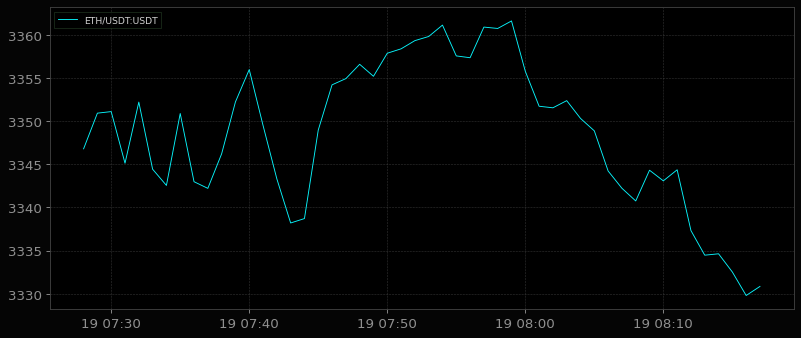

In [94]:
# reader.result[0]['SOL/USDT:USDT'].plot()
reader.result[0]['ETH/USDT:USDT'].plot()

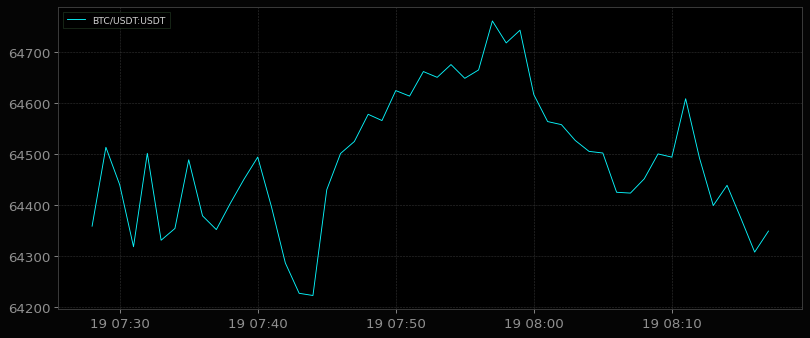

In [95]:
reader.result[0]['BTC/USDT:USDT'].plot()